# Drifter Simulations

***
Based on a notebook by Ben Moore-Maley and modified by Susan Allen

In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from tqdm import tqdm

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Local functions

In [3]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., ./SalishSea/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(path, f'SalishSea_1{res}_{datestr}')
    
    return prefix


def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

***

### Load drifters and definitions

In [4]:
# Define paths
paths = {
    'NEMO': './SalishSea/',
    'coords': './grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': './grid/mesh_mask201702.nc',
    'out': './results',
}

In [5]:
# Duration and timestep [s]
# Duration
duration = timedelta(days=5) # was initially 5 - this is the total duration, or runtime, of the particle simulation
# Timestep
dt = 90 # this is the internal numerical timestep of the simulation in seconds - apparently this should be small, and
# then the output timestep is large, so your oputfile isnt too large i beleive - from OceanParcels tutorial

In [10]:
n = 2   # number of particles, originally 1000
# Define Gaussian point cloud in the horizontal
r = 100   # radius of particle cloud [m] - initially 10,000 (10km)
deg2m = 111000 * np.cos(50 * np.pi / 180) # what is this?
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 1.
dmax = 1.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

In [ ]:
## For my pteropod simulation -don't run the above cell - modify it to launch my pteropod particles at assigned depths
#n = 10 # number of particles


***

### Simulations

In [7]:
# Need to run this cell twice for some reason
start = datetime(2020, 3, 15) # Day that particles initialize
# A combination of a date and a time. Attributes: year, month, day, hour, minute, second, microsecond, and tzinfo.^
# Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days + 1): # was initially (duration.days + 3) - why?? CHANGED
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

field_set = FieldSet.from_nemo(filenames, variables, dimensions)

./SalishSea/SalishSea_1h_20200315_20200315
./SalishSea/SalishSea_1h_20200316_20200316
./SalishSea/SalishSea_1h_20200317_20200317
./SalishSea/SalishSea_1h_20200318_20200318
./SalishSea/SalishSea_1h_20200319_20200319
./SalishSea/SalishSea_1h_20200320_20200320


         It will be opened with no decoding. Filling values might be wrongly parsed.


In [11]:
# Set output file name.  Maybe change for each run
fn = f'matt_drifters_2particles1mdepth' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/matt_drifters_2particles1mdepth20200315_20200320.nc


In [12]:
# Execute run
clon, clat = -123.4, 49.18  # choose horizontal centre of the particle cloud # inital = -123.4, 49.18
lon, lat, z = clon + x_offset, clat + y_offset, zvals
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=1))
# I think this is where I can change the hour that the particles initialize^ Can't be 0 because that puts it outside
# the timerange - I guess technically that would be the previous day at midnight?
pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=dt, # I believe this is where you'd put a - for reverse i.e. -dt
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)), # This is the output timestep - 1hr
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/mn/lkjb39ld1msfdy5zq66q6h8c0000gn/T/parcels-501/d8c18aef6e8c342f1d063a7ece552150_0.so
INFO: Temporary output files are stored in ./results/out-JHCHQIXY.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-JHCHQIXY" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:09:42 Time:  0:09:42


In [13]:
# this cell will fail, but I seem to need to run it to get the outputfiles from the temp directory into my 
# final outfile
pset.execute(fail=fail)

NameError: name 'fail' is not defined

In [14]:
## Can print the particles to see thier coordinates and depth - dont do this if the number of particles is large
print(pset)

P[2](lon=-123.277222, lat=49.441786, depth=1.000000, time=433800.000000)
P[3](lon=-123.438149, lat=49.422838, depth=1.000000, time=433800.000000)


In [25]:
## Easier way to plot? test - the U might not work because its 3D here, not just surface - not working
# pset.show(field=field_set.U, domain={'N':49.8, 'S':48.6, 'E':-122.8 ,'W':-124})

INFO: Visualisation of field with geographic coordinates is not possible. Cartopy not found.


In [15]:
#coords.close()
#mask.close()
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [16]:
ds = xr.open_dataset(outfile)

In [17]:
print(ds)

<xarray.Dataset>
Dimensions:     (obs: 121, traj: 2)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.5
    parcels_mesh:           spherical


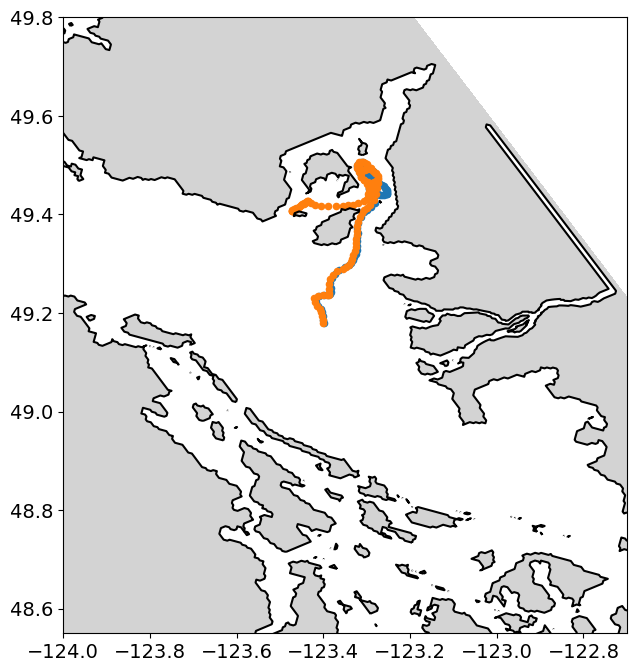

In [18]:
# Plot the paths of all particles
# Initialize a figure and specify the size
fig, ax = plt.subplots(figsize=(19, 8))
# Set the fill colour for the map polygons
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
# Set the line colour for the map polygons ('k' = black)
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
# Set axes limits in map coordinates
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
# Set the aspect ratio
ax.set_aspect(5/4.4)
# Not sure what this does but doesnt seem to affect the plot with it removed (and removed from next line too)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax], s = 20)

# Also need to figure out how to set the color map for only one timestep

# Can just click and drag the figure into a directory to save as a .png - how do you specify the resolution tho?
# save figure this way? fig.savefig('yourfilename.png')
# Can make multiple sub-plots within one figure onject with: fig = plt.subplots(nrows=2, ncols=2)

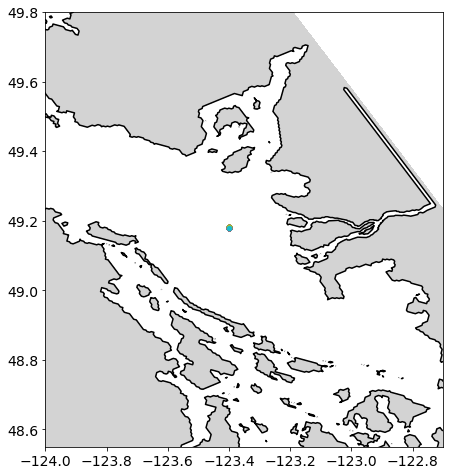

In [32]:
## Plot start locations only
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20)

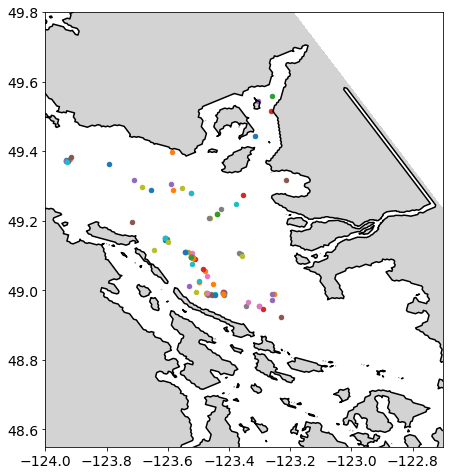

In [33]:
## Plot end locations only
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmax], ds.lat[traj, nmax], s = 20)

100%|██████████| 100/100 [00:03<00:00, 29.22it/s]


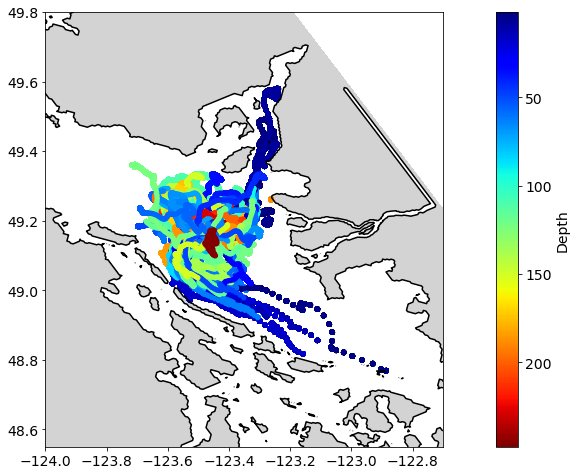

In [18]:
# Make colormapped by depth - takes long time to run
# Initialize a figure and specify the size
fig, ax = plt.subplots(figsize=(19, 8))
# Set the fill colour for the map polygons
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
# Set the line colour for the map polygons ('k' = black)
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
# Set axes limits in map coordinates
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
# Set the aspect ratio
ax.set_aspect(5/4.4)
# Why is nmax -1???
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in tqdm(range(n)):
    s = ax.scatter(ds.lon, ds.lat, s = 20, c = ds['z'], cmap = 'jet')
# Make colorbar for depth
cbar = plt.colorbar(s)
cbar.set_label('Depth')
cbar.ax.invert_yaxis()

# Can just click and drag the figure into a directory to save as a .png - how do you specify the resolution tho?
# save figure this way? fig.savefig('yourfilename.png')
# How to make the points smaller so I can see the paths better?
# Can make multiple sub-plots within one figure onject with: fig = plt.subplots(nrows=2, ncols=2)

100%|██████████| 100/100 [00:00<00:00, 206.82it/s]


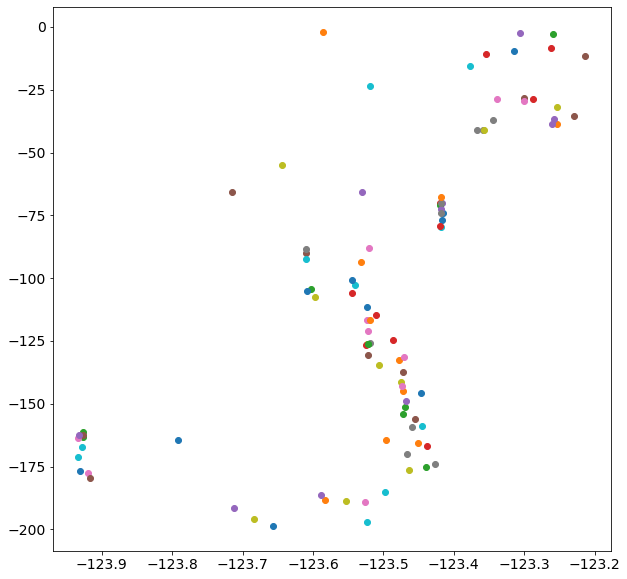

In [30]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in tqdm(range(n)):
    ax.plot(ds.lon[traj, nmax], -ds.z[traj, nmax], 'o')

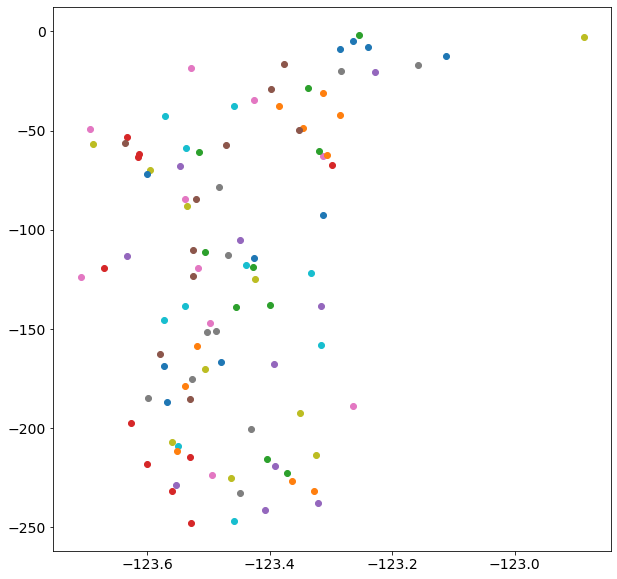

In [20]:
# Make same fig as above but with scatter instead of plot
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    ax.scatter(ds.lon[traj, nmax], -ds.z[traj, nmax], s = None)

100%|██████████| 100/100 [00:03<00:00, 26.19it/s]


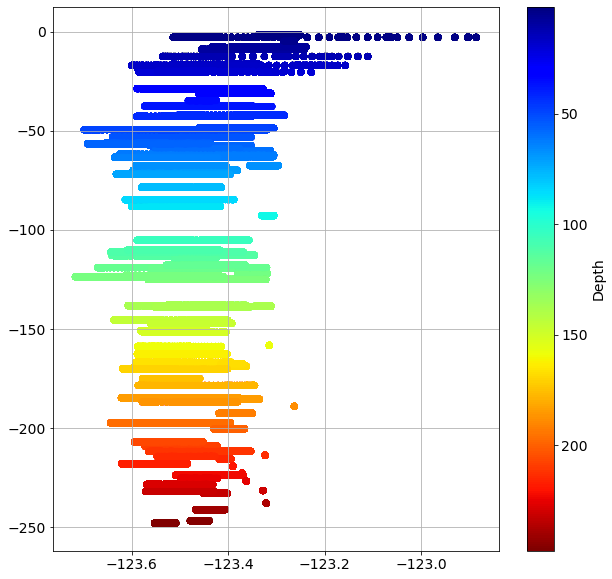

In [22]:
# Trying to make vertical slice colormapped by depth - not working
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in tqdm(range(n)):
    ax.scatter(ds['lon'], -ds['z'], s = None, c = ds['z'], cmap = 'jet')
# ax.scatter(ds['lon'], -ds['z'], s = None, c = ds['z'], cmap = 'jet') works the same as:
# ax.scatter(ds.lon, -ds.z, s = None, c = ds['z'], cmap = 'jet')
ax.grid()
cbar = plt.colorbar(s)
cbar.set_label('Depth')
cbar.ax.invert_yaxis()

In [287]:
# NEED to run this to close the data set before tweaking it for another run - do I tho? I think just renaming the 
# outfile fixes that
ds.close()

ValueError: 'c' argument has 100 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

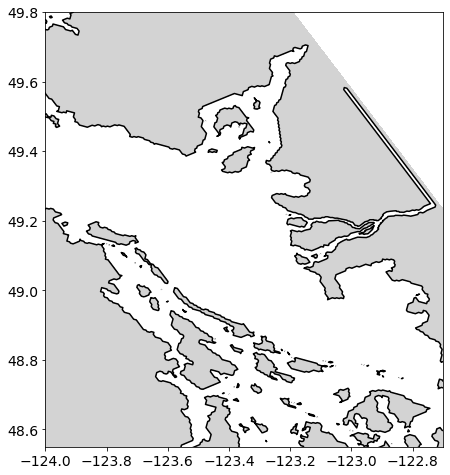

In [25]:
# Attempt to animate

# Time index
timerange = ['2020 Mar 15 02:00', '2020 Mar 22 02:00']
time_ind = parse(timerange[0])

# nmin index
nmin, nmax = 0 , -1

fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)

for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20, c = ds['z'], cmap = 'jet') # remove colormapping?

# Add timestamp
TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes) 
    
# Also need to figure out how to set the color map for only one timestep

# Make colorbar for depth
#cbar = plt.colorbar(s)
#cbar.set_label('Depth')
#cbar.ax.invert_yaxis()



In [26]:
def make_figure(time_ind, nmin, nmax, ax, s, ds):
    """
    """
    
    for traj in range(n):
        s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20)
    
    # Add timestamp
    TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)
    
    # Return plot objects as dictionary
    PLOT_OBJS = {'s': s, 'TEXT_OBJ': TEXT_OBJ}
    
    return ds, PLOT_OBJS

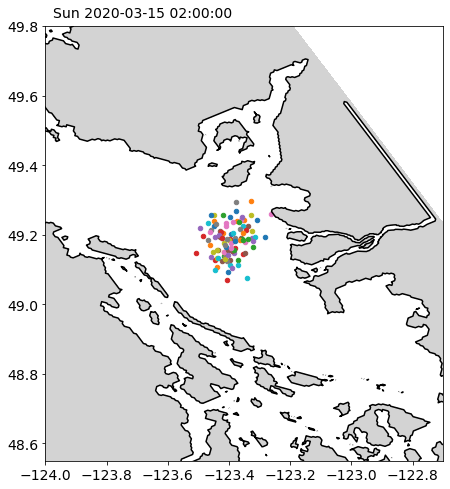

In [27]:
# Time index
time_ind = parse(timerange[0])
# nmin index
nmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(time_ind, nmin, nmax, ax, s, ds)

plt.show()

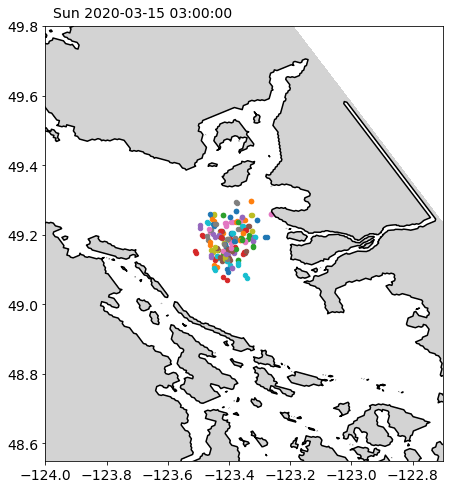

In [28]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime + timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Clear previous particle locations - I'm not using contours so this doesnt work...
#for C in PLOT_OBJS['s'].collections:
    #C.remove()

# Update particle locations
for traj in range(n):
        PLOT_OBJS['s'] = ax.scatter(ds.lon[traj, nmin],
                       ds.lat[traj, nmin], s = 20)

# Update timestamp
PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

plt.show()

In [29]:
def update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS):
    """
    """
    
    # Update particle locations
    for traj in range(n):
        PLOT_OBJS['s'] = ax.scatter(ds.lon[traj, nmin],
                       ds.lat[traj, nmin], s = 20)
    
    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

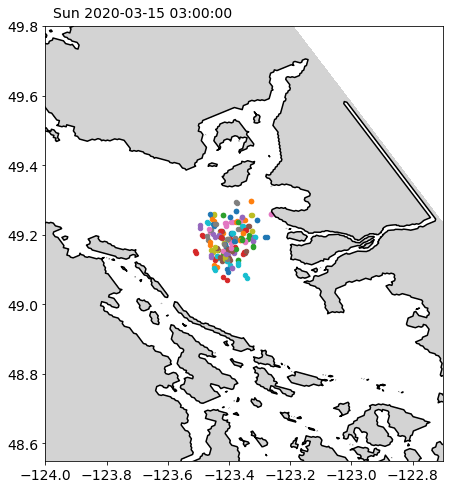

In [30]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime + timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Update figure
PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)

plt.show()

IndexError: index 121 is out of bounds for axis 1 with size 121

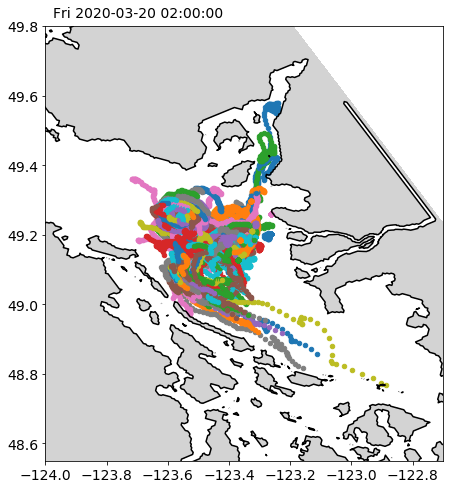

In [31]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.7])
ax.set_ylim([48.55, 49.8])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

def next_frame(t, PLOT_OBJS):
    # Step time index forward
    time_ind = starttime + timedelta(hours=t)
    # Step nmin index forward
    nmin = newnmin + t

    # Update figure
    PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)
    
    return PLOT_OBJS

# Animate
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=169) # update the number of frames?
mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
ANI.save('./Plots/mymovie8.mp4', writer=mywriter)

Now try to place the particles in the JdF and run the simulation backwards.
First try to only simulate one timestep or something, so that I can quickly check the starting locations and depths before running the full simulation

In [8]:
# Duration and timestep [s]
# Duration
duration = timedelta(days = 7) # was initially days=7, this is the total duration, or runtime, of the particle simulation
# Timestep
dt = 90 # this is the internal numerical timestep of the simulation in seconds - apparently this should be small, and
# then the output timestep is large, so your oputfile isnt too large i beleive - from OceanParcels tutorial

In [9]:
n = 1000   # number of particles, originally 1000
# Define Gaussian point cloud in the horizontal
r = 8000   # radius of particle cloud [m] - initially 10,000 (10km)
deg2m = 111000 * np.cos(50 * np.pi / 180) # what is this?
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 200.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

In [10]:
# Need to run this cell twice for some reason
start = datetime(2020, 3, 15) # Day that particles initialize
# A combination of a date and a time. Attributes: year, month, day, hour, minute, second, microsecond, and tzinfo.^
# Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days + 1): # was initially (duration.days + 3) - why?? CHANGED for some reason you can't 
    # make the runtime the full 8 days, you have to do 7 and add a day here...
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

field_set = FieldSet.from_nemo(filenames, variables, dimensions)

         It will be opened with no decoding. Filling values might be wrongly parsed.


./SalishSea/SalishSea_1h_20200315_20200315
./SalishSea/SalishSea_1h_20200316_20200316
./SalishSea/SalishSea_1h_20200317_20200317
./SalishSea/SalishSea_1h_20200318_20200318
./SalishSea/SalishSea_1h_20200319_20200319
./SalishSea/SalishSea_1h_20200320_20200320
./SalishSea/SalishSea_1h_20200321_20200321
./SalishSea/SalishSea_1h_20200322_20200322


In [11]:
# Set output file name.  Maybe change for each run
fn = f'matt_drifters_JdF1000particles0to200m' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

./results/matt_drifters_JdF1000particles0to200m20200315_20200322.nc


In [203]:
# Execute run
clon, clat = -123.72, 48.24  # choose horizontal centre of the particle cloud # inital = -123.4, 49.18
lon, lat, z = clon + x_offset, clat + y_offset, zvals
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z) # time=start+timedelta(hours=1)
# I think this is where I can change the hour that the particles initialize^ Can't be 0 because that puts it outside
# the timerange - I guess technically that would be the previous day at midnight?
pset.execute(
    pset.Kernel(AdvectionRK4), runtime=duration, dt=-dt, # I believe this is where you'd put a - for reverse i.e. -dt
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)), # This is the output timestep - 1hr
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/mn/lkjb39ld1msfdy5zq66q6h8c0000gn/T/parcels-501/a151c47037327bf67678628cfdd8e32c_0.so
INFO: Temporary output files are stored in ./results/out-MNHCTQPT.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-MNHCTQPT" to convert these to a NetCDF file during the run.
 67% (410400.0 of 604800.0) |########    | Elapsed Time: 0:08:32 ETA:   0:04:46

Particle 1913 lost !! [-124.7848649092743, 48.505047837393576, 71.03747136341228, 273690.0]
Particle 2508 lost !! [-124.77818412658918, 48.49707669989567, 70.65868146136283, 274140.0]



 68% (414000.0 of 604800.0) |########    | Elapsed Time: 0:08:37 ETA:   0:04:05

Particle 1917 lost !! [-124.77813673096061, 48.49702020935, 79.27960396845255, 271260.0]
Particle 2349 lost !! [-124.78486723896246, 48.50505061410353, 106.98895446144961, 271080.0]
Particle 2592 lost !! [-124.77814107721801, 48.497025388845515, 76.2628237864292, 271530.0]


 80% (489600.0 of 604800.0) |#########   | Elapsed Time: 0:11:15 ETA:   0:04:35

Particle 2332 lost !! [-124.78823583963596, 48.5090614418838, 90.80728543475101, 195210.0]



 81% (493200.0 of 604800.0) |#########   | Elapsed Time: 0:11:24 ETA:   0:04:30

Particle 1630 lost !! [-124.76141174822139, 48.47707860086431, 92.58142005542554, 190980.0]
Particle 2119 lost !! [-124.76148260110371, 48.47716304192835, 107.35361801267622, 191160.0]



 82% (496800.0 of 604800.0) |#########   | Elapsed Time: 0:11:32 ETA:   0:04:16

Particle 1714 lost !! [-124.79479969889837, 48.51688047992238, 105.08301877427076, 187920.0]
Particle 2004 lost !! [-124.77820229557048, 48.49709846352756, 93.80149025545717, 188100.0]
Particle 2150 lost !! [-124.78150636235455, 48.501045121816766, 98.48079828537419, 188280.0]
Particle 2453 lost !! [-124.76153093290631, 48.477220642223216, 91.45468227907398, 189810.0]



 82% (500400.0 of 604800.0) |#########   | Elapsed Time: 0:11:41 ETA:   0:04:14

Particle 1726 lost !! [-124.77809056463987, 48.49696527484344, 87.83644202884497, 185220.0]
Particle 2008 lost !! [-124.79822037614541, 48.520957011216865, 110.27941485400541, 185220.0]
Particle 2394 lost !! [-124.77823083911474, 48.4971324477199, 109.6339888407885, 185310.0]
Particle 2549 lost !! [-124.7781264612178, 48.4970080592953, 96.07680306139763, 183780.0]



 83% (504000.0 of 604800.0) |##########  | Elapsed Time: 0:11:50 ETA:   0:04:01

Particle 1742 lost !! [-124.78152581430903, 48.50106828301403, 93.65220538236403, 180450.0]
Particle 1899 lost !! [-124.7882246211344, 48.50904808708672, 102.99861725891648, 180270.0]
Particle 1942 lost !! [-124.77816711426836, 48.49705646162061, 107.21983779426714, 182340.0]
Particle 1961 lost !! [-124.77821675488079, 48.49711562305568, 87.10361802483388, 182430.0]
Particle 2295 lost !! [-124.79160950959158, 48.51308206224535, 104.32308754492468, 181620.0]
Particle 2342 lost !! [-124.7781251818723, 48.49700652669964, 98.75256554561982, 182160.0]
Particle 2379 lost !! [-124.77822979160285, 48.497131234068824, 89.50034242103226, 181170.0]
Particle 2561 lost !! [-124.80495308796907, 48.52897327049271, 97.5121241328041, 182700.0]



 83% (507600.0 of 604800.0) |##########  | Elapsed Time: 0:11:59 ETA:   0:04:00

Particle 2315 lost !! [-124.77812068547613, 48.497001085427904, 87.18501408957752, 178380.0]


 95% (579600.0 of 604800.0) |########### | Elapsed Time: 0:14:42 ETA:   0:00:56

Particle 1924 lost !! [-124.76152237484308, 48.47721045964182, 100.60457541481038, 105210.0]
Particle 2347 lost !! [-124.7447811091384, 48.457245691096254, 89.27193541871002, 105570.0]



 96% (583200.0 of 604800.0) |########### | Elapsed Time: 0:14:51 ETA:   0:00:49

Particle 1691 lost !! [-124.77811640026776, 48.49699597747727, 107.69104729423877, 102150.0]
Particle 1731 lost !! [-124.7781652491361, 48.49705419458246, 91.76574784379096, 100980.0]



 97% (586800.0 of 604800.0) |########### | Elapsed Time: 0:14:59 ETA:   0:00:42

Particle 2569 lost !! [-124.76145524578071, 48.47713043999084, 104.80314701208397, 97380.0]



 97% (590400.0 of 604800.0) |########### | Elapsed Time: 0:15:08 ETA:   0:00:37

Particle 1632 lost !! [-124.77819974640754, 48.49709530694357, 100.0331035562069, 94050.0]
Particle 1795 lost !! [-124.78153533813648, 48.50107962983836, 100.31869685053212, 95940.0]
Particle 2067 lost !! [-124.76151411372163, 48.47720060488715, 82.87343426417151, 96930.0]
Particle 2091 lost !! [-124.76150630616979, 48.47719129365359, 88.23056200014084, 97020.0]
Particle 2334 lost !! [-124.77813811083945, 48.49702185132254, 99.86294910196834, 93870.0]



 98% (594000.0 of 604800.0) |########### | Elapsed Time: 0:15:17 ETA:   0:00:25

Particle 1828 lost !! [-124.7949017105967, 48.51700189579283, 125.11549925835452, 91710.0]


100% (604800.0 of 604800.0) |############| Elapsed Time: 0:15:41 Time:  0:15:41


In [204]:
# this cell will fail, but I seem to need to run it to get the outputfiles from the temp directory into my 
# final outfile
pset.execute(fail=fail)

NameError: name 'fail' is not defined

In [15]:
#coords.close()
#mask.close()
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [16]:
ds = xr.open_dataset(outfile)

In [17]:
print(ds)

<xarray.Dataset>
Dimensions:     (obs: 169, traj: 1000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.5
    parcels_mesh:           spherical


In [18]:
# NEED to run this to close the data set before tweaking it for another run, or I can just rename the outfile
ds.close()

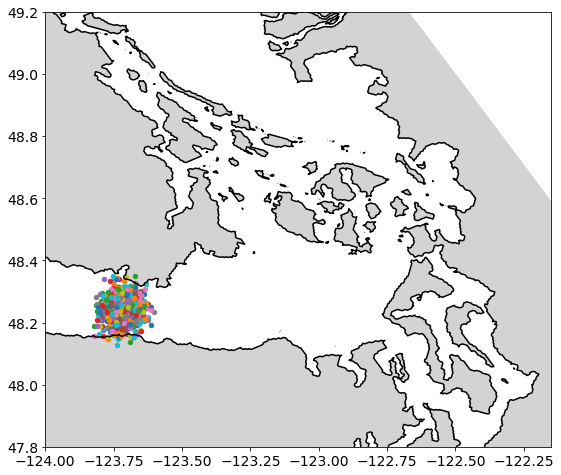

In [19]:
## Plot start locations only
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20)

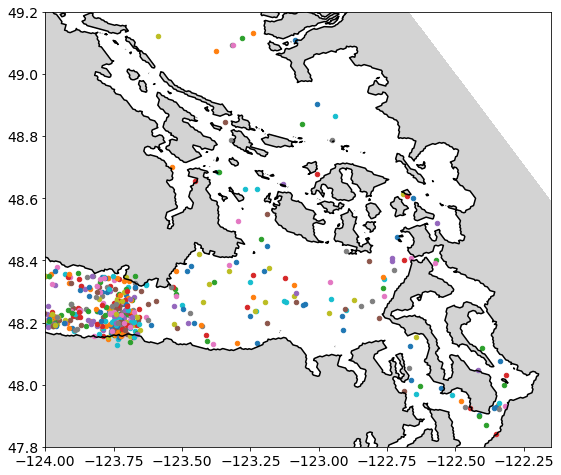

In [20]:
## Plot end locations only
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmax], ds.lat[traj, nmax], s = 20)

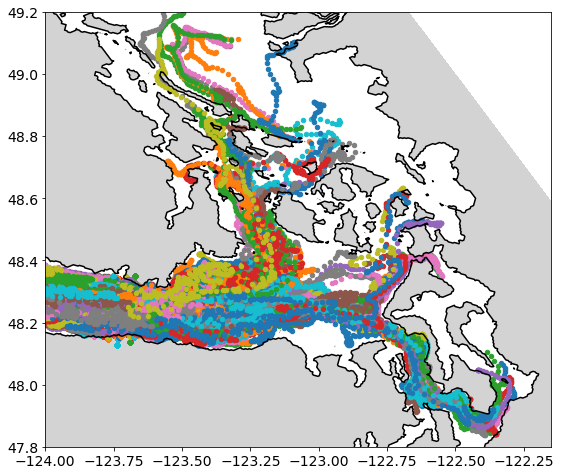

In [21]:
# Plot entire paths
## Plot end locations only
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
# Loops through the data set in range(n) which means the size of the dataset, and s is defined as the image I think
for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin:nmax], ds.lat[traj, nmin:nmax], s = 20)

100%|██████████| 1000/1000 [00:04<00:00, 244.17it/s]


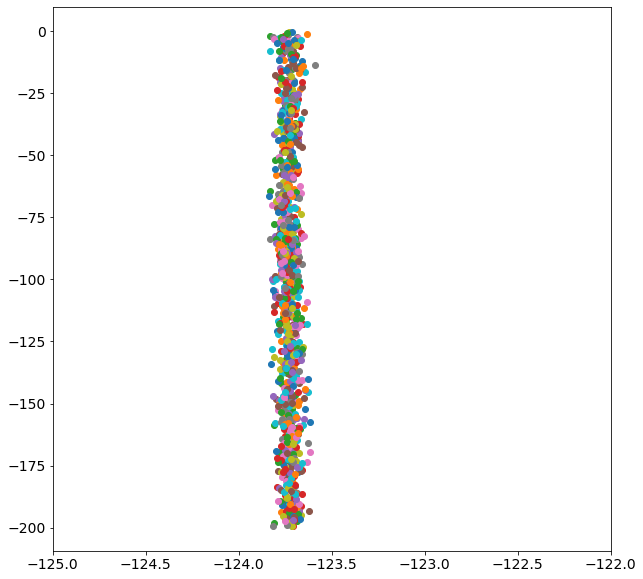

In [50]:
# Plot starting depth profile of particles
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])
for traj in tqdm(range(n)):
    ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')

100%|██████████| 1000/1000 [00:06<00:00, 155.10it/s]


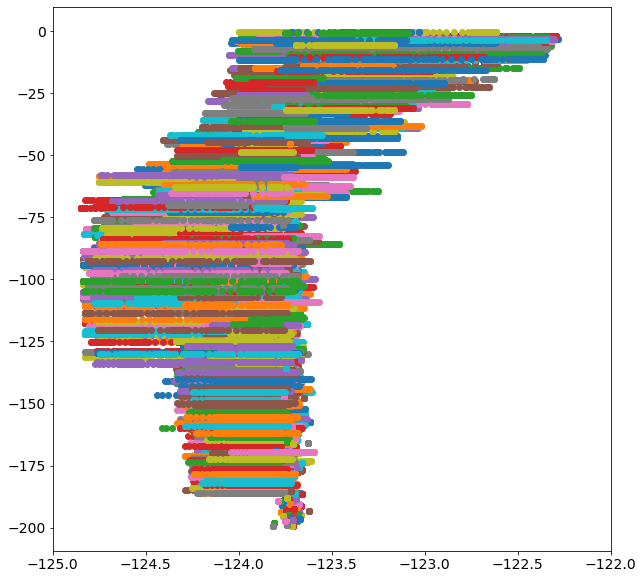

In [49]:
# Plot end depth profile of particles
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])
for traj in tqdm(range(n)):
    ax.plot(ds.lon[traj, nmin:nmax], -ds.z[traj, nmin:nmax], 'o')

100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


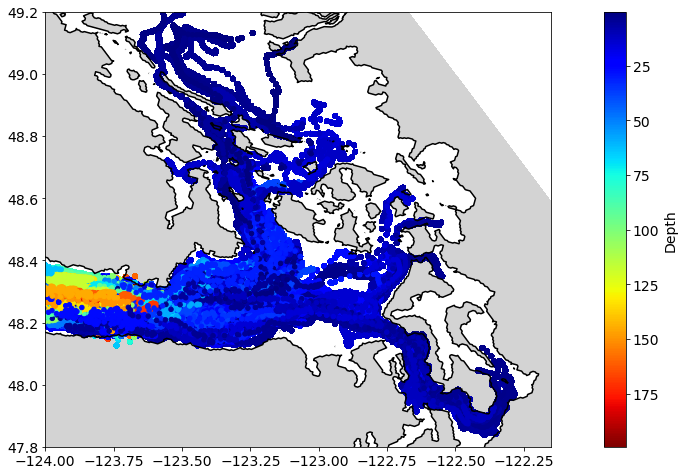

In [214]:
# Make colormapped by depth - takes long time to run
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in tqdm(range(n)):
    s = ax.scatter(ds.lon, ds.lat, s = 20, c = ds['z'], cmap = 'jet')
# Make colorbar for depth
cbar = plt.colorbar(s)
cbar.set_label('Depth')
cbar.ax.invert_yaxis()

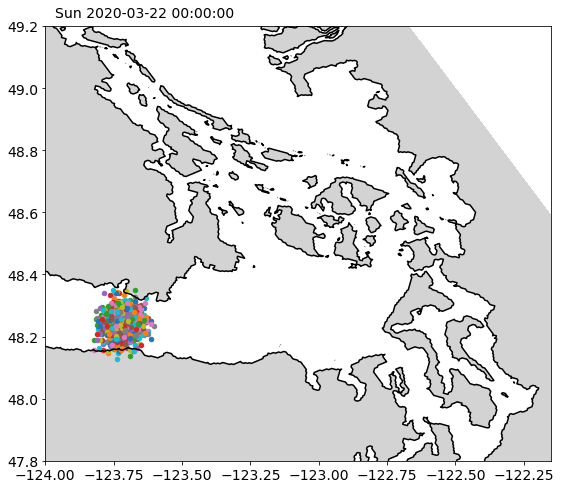

In [22]:
# Attempt to animate

# Time index
timerange = ['2020 Mar 22 00:00', '2020 Mar 15 00:00']
time_ind = parse(timerange[0])

# nmin index
nmin, nmax = 0 , -1

fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)

for traj in range(n):
    s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20)

# Add timestamp
TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes) 
    
# Also need to figure out how to set the color map for only one timestep

# Make colorbar for depth
#cbar = plt.colorbar(s)
#cbar.set_label('Depth')
#cbar.ax.invert_yaxis()

In [23]:
def make_figure(time_ind, nmin, nmax, ax, s, ds):
    """
    """
    
    for traj in range(n):
        s = ax.scatter(ds.lon[traj, nmin], ds.lat[traj, nmin], s = 20)
    
    # Add timestamp
    TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)
    
    # Return plot objects as dictionary
    PLOT_OBJS = {'s': s, 'TEXT_OBJ': TEXT_OBJ}
    
    return ds, PLOT_OBJS

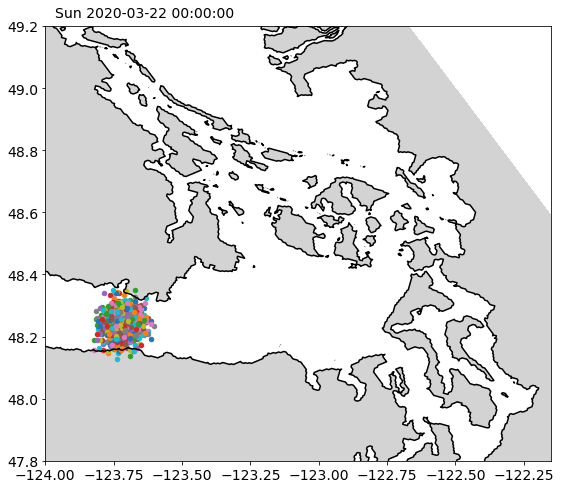

In [24]:
# Time index
time_ind = parse(timerange[0])
# nmin index
nmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(time_ind, nmin, nmax, ax, s, ds)

plt.show()

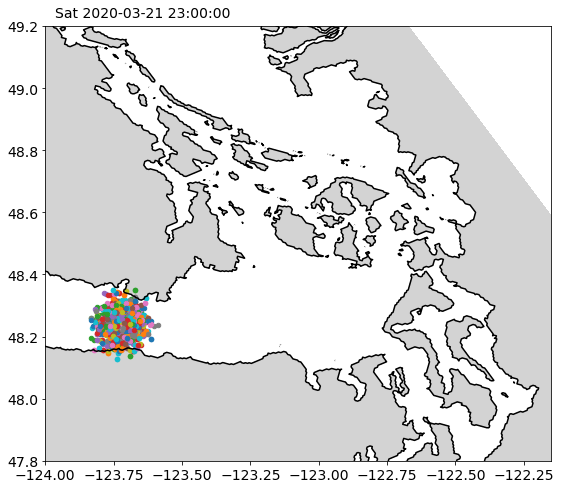

In [25]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Clear previous particle locations - I'm not using contours so this doesnt work...
#for C in PLOT_OBJS['s'].collections:
    #C.remove()

# Update particle locations
for traj in range(n):
        PLOT_OBJS['s'] = ax.scatter(ds.lon[traj, nmin],
                       ds.lat[traj, nmin], s = 20)

# Update timestamp
PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

plt.show()

In [26]:
def update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS):
    """
    """
    
    # Update particle locations
    for traj in range(n):
        PLOT_OBJS['s'] = ax.scatter(ds.lon[traj, nmin],
                       ds.lat[traj, nmin], s = 20)
    
    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

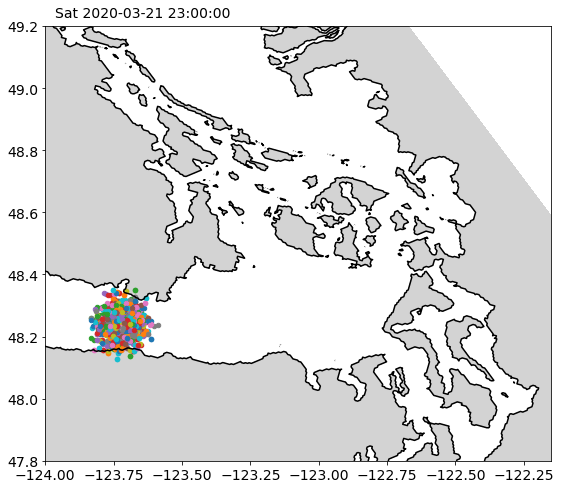

In [27]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Update figure
PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)

plt.show()

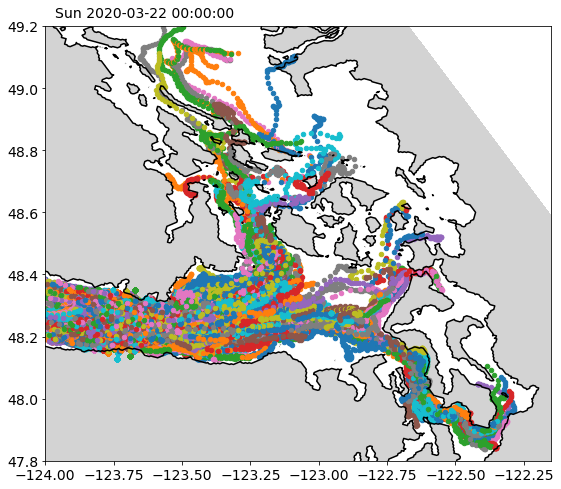

In [28]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124., -122.15])
ax.set_ylim([47.8, 49.2])
ax.set_aspect(5/4.4)

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

def next_frame(t, PLOT_OBJS):
    # Step time index forward
    time_ind = starttime - timedelta(hours=t)
    # Step nmin index forward
    nmin = newnmin + t

    # Update figure
    PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)
    
    return PLOT_OBJS

# Animate
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=168) # update the number of frames?
mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
ANI.save('./Plots/mymovie10.mp4', writer=mywriter)

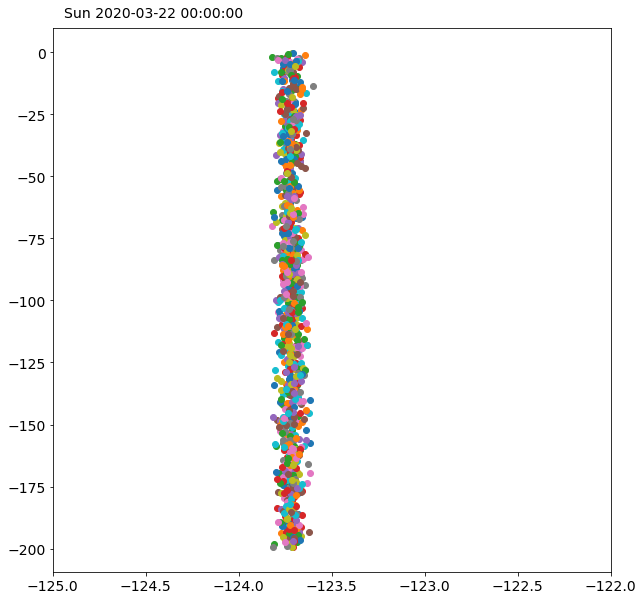

In [84]:
# Attempt to animate the vertical slice depth profile of particles
    
# Time index
timerange = ['2020 Mar 22 00:00', '2020 Mar 15 00:00'] # I don't think this start time is correct - maybe 23:00?
time_ind = parse(timerange[0])

# nmin index
nmin, nmax = 0 , -1

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])
for traj in range(n):
    s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')

# Add timestamp
TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

In [85]:
def make_figure(time_ind, nmin, nmax, ax, s, ds):
    """
    """
    
    for traj in range(n):
        s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o') # this just plots the very first frame
    
    # Add timestamp
    TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)
    
    # Return plot objects as dictionary
    PLOT_OBJS = {'s': s, 'TEXT_OBJ': TEXT_OBJ}
    
    return ds, PLOT_OBJS

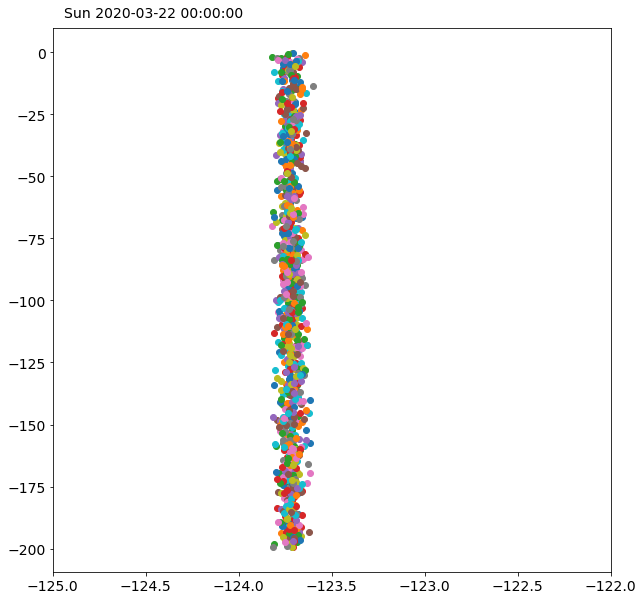

In [86]:
# Time index
time_ind = parse(timerange[0])
# nmin index
nmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(time_ind, nmin, nmax, ax, s, ds)

plt.show()

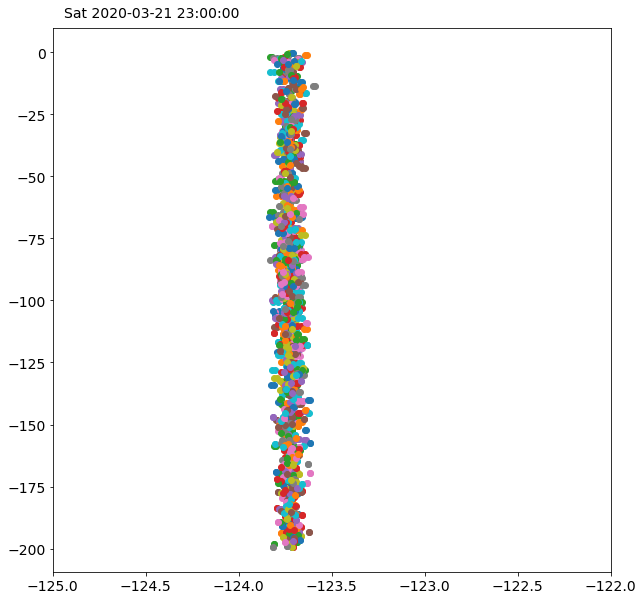

In [97]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Update particle locations
for traj in range(n):
        PLOT_OBJS['s'] = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')
        
# Update timestamp
PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

plt.show()

In [98]:
def update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS):
    """
    """
        
    # Update particle locations
    for traj in range(n):
        s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')
    
    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

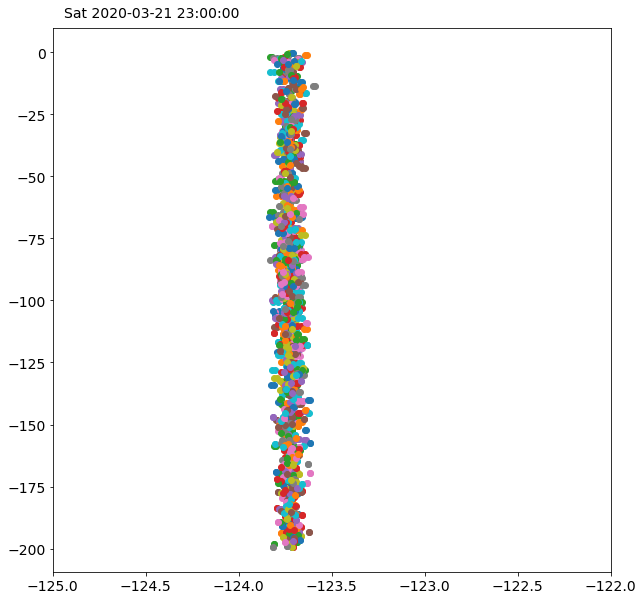

In [99]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Update figure
PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)

plt.show()

KeyError: 's'

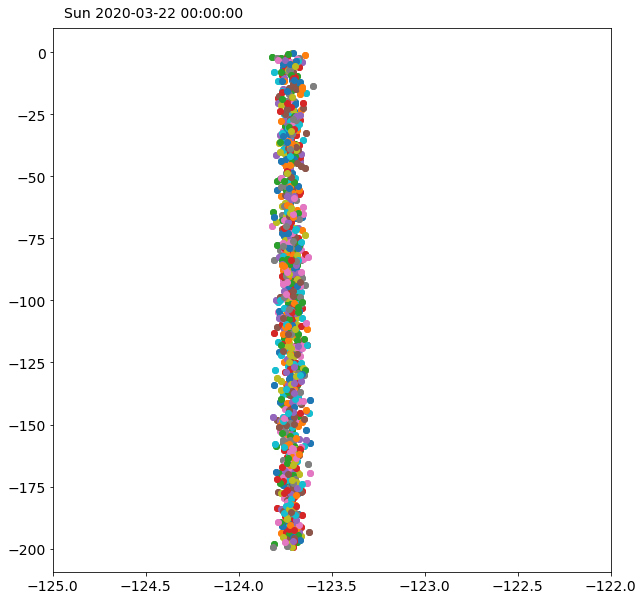

In [100]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

def next_frame(t, PLOT_OBJS):
    # Step time index forward
    time_ind = starttime - timedelta(hours=t)
    # Step nmin index forward
    nmin = newnmin + t
        
    # Update figure
    PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)
    
    return PLOT_OBJS

# Animate
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=12) # update the number of frames?
mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
ANI.save('./Plots/mymovie14.mp4', writer=mywriter)

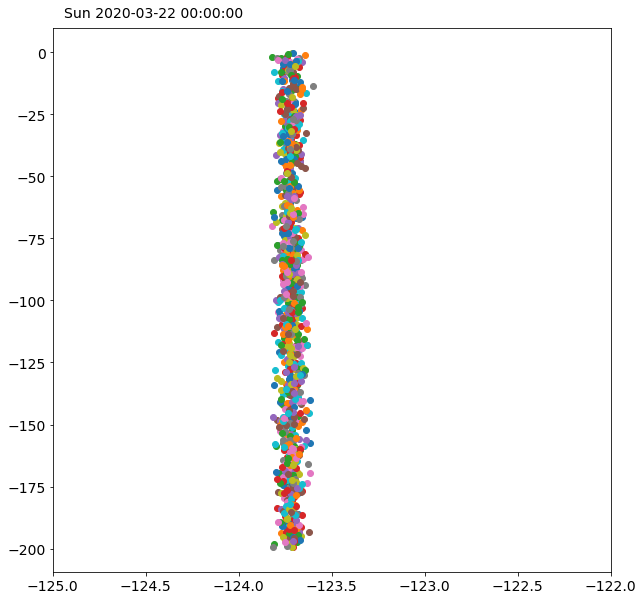

In [101]:
## Attempt to make the animation without plotting the previous frame or something - might need to get rid of the dictionary

# Time index
timerange = ['2020 Mar 22 00:00', '2020 Mar 15 00:00'] # I don't think this start time is correct - maybe 23:00?
time_ind = parse(timerange[0])

# nmin index
nmin, nmax = 0 , -1

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])
for traj in range(n):
    s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')

# Add timestamp
TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

In [102]:
def make_figure(time_ind, nmin, nmax, ax, s, ds):
    """
    """
    
    for traj in range(n):
        s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o') # this just plots the very first frame
    
    # Add timestamp
    TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)
    
    # Return plot objects as dictionary
    # PLOT_OBJS = {'s': s, 'TEXT_OBJ': TEXT_OBJ}
    
    return ds, s

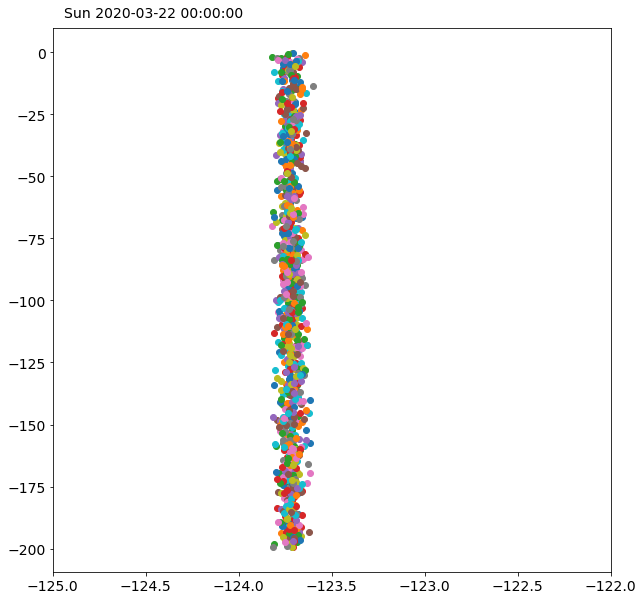

In [103]:
# Time index
time_ind = parse(timerange[0])
# nmin index
nmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, s = make_figure(time_ind, nmin, nmax, ax, s, ds)

plt.show()

In [ ]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, s = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Clear previous points not working
s.remove()

# Update particle locations
for traj in range(n):
        s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')
        
# Update timestamp
TEXT_OBJ.set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

plt.show()

In [ ]:
def update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS):
    """
    """
        
    # Update particle locations
    for traj in range(n):
        s = ax.plot(ds.lon[traj, nmin], -ds.z[traj, nmin], 'o')
    
    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

In [ ]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

# Step time index forward
time_ind = starttime - timedelta(hours=1)
# Step nmin index forward
nmin = newnmin + 1

# Update figure
PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)

plt.show()

In [ ]:
# Time index
starttime = parse(timerange[0])
# nmin index
newnmin, nmax = 0, -1

# Make figure window
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125., -122.])

# Make figure
ds, PLOT_OBJS = make_figure(starttime, newnmin, nmax, ax, s, ds)

def next_frame(t, PLOT_OBJS):
    # Step time index forward
    time_ind = starttime - timedelta(hours=t)
    # Step nmin index forward
    nmin = newnmin + t
        
    # Update figure
    PLOT_OBJS = update_figure(time_ind, nmin, nmax, ax, s, ds, PLOT_OBJS)
    
    return PLOT_OBJS

# Animate
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=12) # update the number of frames?
mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
ANI.save('./Plots/mymovie14.mp4', writer=mywriter)